## Least Squares Moving avarage
You run an OLS regression for a certain window (n)

X = Day0, Day1....

y = Close Price

For each day you need a prediction based on this regression over the past n days

In [1]:
!pip install yfinance   # for gathering the finance data

  Attempting uninstall: pytz
    Found existing installation: pytz 2021.3
    Uninstalling pytz-2021.3:
      Successfully uninstalled pytz-2021.3
  Attempting uninstall: lxml
    Found existing installation: lxml 4.8.0
    Uninstalling lxml-4.8.0:
      Successfully uninstalled lxml-4.8.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [3]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib as plt

In [4]:
df = yf.download('AAPL',start="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.561539,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.846367,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.426819,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.081490,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.257111,132079200
...,...,...,...,...,...,...
2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160080100
2022-12-19,135.110001,135.199997,131.320007,132.369995,132.369995,79592600
2022-12-20,131.389999,133.250000,129.889999,132.300003,132.300003,77432800


In [7]:
#run regression on just in first row
window = 25
test_df = df[:window] #25 rows

In [10]:
#for linear reg, we have to define our depenent variable
y_ = test_df.Close
y_

Date
2020-01-02    75.087502
2020-01-03    74.357498
2020-01-06    74.949997
2020-01-07    74.597504
2020-01-08    75.797501
2020-01-09    77.407501
2020-01-10    77.582497
2020-01-13    79.239998
2020-01-14    78.169998
2020-01-15    77.834999
2020-01-16    78.809998
2020-01-17    79.682503
2020-01-21    79.142502
2020-01-22    79.425003
2020-01-23    79.807503
2020-01-24    79.577499
2020-01-27    77.237503
2020-01-28    79.422501
2020-01-29    81.084999
2020-01-30    80.967499
2020-01-31    77.377502
2020-02-03    77.165001
2020-02-04    79.712502
2020-02-05    80.362503
2020-02-06    81.302498
Name: Close, dtype: float64

In [13]:
#our independent variable should be date but we have to convert it into integer values
X_=pd.Series(range(len(test_df.index))).values
X_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [15]:
#define the model 
model_ = sm.OLS(y_,sm.add_constant(X_)).fit()

In [16]:
model_.params

const    75.714038
x1        0.210839
dtype: float64

In [18]:
model_.predict()[-1]

80.77416269155644

## Running all regressions

In [27]:
lsma_arr = []
dates_arr = []

for i in range(len(df)-24):
    input_reg = df[i:25+i]
    X = pd.Series(range(len(input_reg.index))).values
    y = input_reg.Close
    model = sm.OLS(y,sm.add_constant(X)).fit()
    pred = model.predict()[-1]
    lsma_arr.append(pred)
    dates_arr.append(input_reg.iloc[-1].name)

## Data handling

In [28]:
lsma_df = pd.DataFrame({'LSMA':lsma_arr},index = dates_arr)

In [30]:
all_df = pd.concat([lsma_df,df],axis = 1)

In [32]:
all_df.dropna(inplace=True)

## Simple trading strat using the indicator


In [34]:
all_df['signal_buy'] = all_df.Close < all_df.LSMA
all_df['signal_sell'] = all_df.Close > all_df.LSMA

In [35]:
all_df['shifted_open'] = all_df.Open.shift(-1)

In [56]:
in_position = False

buydates , selldates = [], []
buyprices, sellprices = [], []

for index,row in all_df.iterrows():
    if not in_position and row.signal_buy == True:
        buyprice = row.shifted_open
        buyprices.append(buyprice)
        buydates.append(index)
        in_position = True

    if in_position and row.signal_sell == True:
        sellprice = row.shifted_open
        sellprices.append(sellprice)
        selldates.append(index)
        in_position = False


## Results and profit calculations from the predictions

In [57]:
profits = pd.Series([(sell - buy)/buy for sell,buy in zip(sellprices,buyprices)])

In [61]:
(profits+1).prod()

2.140942402928979

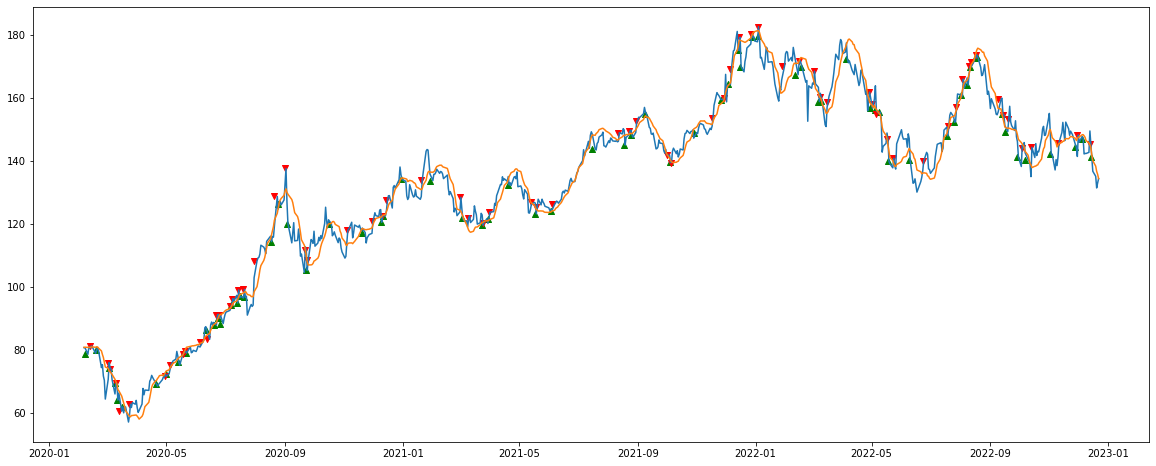

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(all_df[['Open','LSMA']])
plt.scatter(buydates,all_df.loc[buydates].shifted_open,marker='^',color="green")
plt.scatter(selldates,all_df.loc[selldates].shifted_open,marker='v',color ="red")

,LSMA,Open,High,Low,Close,Adj Close,Volume,signal_buy,signal_sell,shifted_open
2020-02-06,80.774163,80.642502,81.305000,80.065002,81.302498,79.650238,105425600,False,True,80.592499
2020-02-07,80.787501,80.592499,80.849998,79.500000,80.007500,78.567581,117684000,True,False,78.544998
2020-02-10,80.754316,78.544998,80.387497,78.462502,80.387497,78.940742,109348800,True,False,80.900002
2020-02-11,80.639746,80.900002,80.974998,79.677498,79.902496,78.464462,94323200,True,False,80.367500
2020-02-12,80.737346,80.367500,81.805000,80.367500,81.800003,80.327827,113730400,False,True,81.047501
...,...,...,...,...,...,...,...,...,...,...
2022-12-16,140.039602,136.690002,137.649994,133.729996,134.509995,134.509995,160080100,True,False,135.110001
2022-12-19,138.324925,135.110001,135.199997,131.320007,132.369995,132.369995,79592600,True,False,131.389999
2022-12-20,136.646064,131.389999,133.250000,129.889999,132.300003,132.300003,77432800,True,False,132.979996
2022-12-21,135.730432,132.979996,136.809998,132.750000,135.449997,135.449997,85928000,True,False,134.350006
